In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: pho
"""
%load_ext autoreload
%autoreload 2
import sys
import importlib
from threading import Thread
import time # for time.sleep
from ipygany import PolyMesh, Scene, IsoColor, WarpByScalar
import pyvista as pv
# from pyvista import _vtk
import pyvistaqt as pvqt
import colorcet as cc # Colormaps:
import numpy as np
import pandas as pd
import h5py
import hdf5storage # conda install hdf5storage
from pathlib import Path
import bqplot.scales
import seaborn as sns
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize, to_rgba_array
# import mplcursors
import math # For color map generation
from matplotlib.colors import ListedColormap
from matplotlib.cm import hsv

import ipywidgets as widgets
# from PyQt5 import QtWidgets, uic
from pyvistaqt import QtInteractor, MainWindow
# from pyqt6 import QApplication
from IPython.external.qt_for_kernel import QtGui
from PyQt5.QtWidgets import QApplication

import datetime as dt
import panel as pn # for interactive widgets
pn.extension()

In [13]:
# import PhoPositionalData as pdp
# from PhoPositionalData import load_exported, process_data
from PhoPositionalData.load_exported import *
# from PhoPositionalData.process_data import process_positionalAnalysis_data, gen_2d_histrogram, get_heatmap_color_vectors, process_chunk_equal_poritions_data, extract_spike_timeseries
from PhoPositionalData.process_data import *
from PhoPositionalData.plot_data import *
from PhoPositionalData.plotting.animations import * # make_mp4_from_plotter
from PhoPositionalData.import_data import * # build_spike_positions_list, build_cellID_reverse_lookup_map
from PhoPositionalData.analysis.interactive_placeCell_config import InteractivePlaceCellConfig, VideoOutputModeConfig, PlottingConfig, PlacefieldComputationParameters  # VideoOutputModeConfig, InteractivePlaceCellConfigs
from PhoPositionalData.analysis.interactive_placeCell_config import print_subsession_neuron_differences

def debug_print_spike_counts(session):
    uniques, indicies, inverse_indicies, count_arr = np.unique(active_epoch_session.spikes_df['aclu'].values, return_index=True, return_inverse=True, return_counts=True)
    # count_arr = np.bincount(active_epoch_session.spikes_df['aclu'].values)
    print('active_epoch_session.spikes_df unique aclu values: {}'.format(uniques))
    print('active_epoch_session.spikes_df unique aclu value counts: {}'.format(count_arr))
    print(len(uniques)) # 69 
    uniques, indicies, inverse_indicies, count_arr = np.unique(active_epoch_session.spikes_df['unit_id'].values, return_index=True, return_inverse=True, return_counts=True)
    # count_arr = np.bincount(active_epoch_session.spikes_df['unit_id'].values)
    print('active_epoch_session.spikes_df unique unit_id values: {}'.format(uniques))
    print('active_epoch_session.spikes_df unique unit_id value counts: {}'.format(count_arr))
    
    print(len(uniques)) # 69 
    

In [3]:
# NeuroPy (Diba Lab Python Repo) Loading
try:
    from neuropy import core
    importlib.reload(core)
except ImportError:
    sys.path.append(r'C:\Users\Pho\repos\NeuroPy') # Windows
    # sys.path.append('/home/pho/repo/BapunAnalysis2021/NeuroPy') # Linux
    # sys.path.append(r'/Users/pho/repo/Python Projects/NeuroPy') # MacOS
    print('neuropy module not found, adding directory to sys.path. \n >> Updated sys.path.')
    from neuropy import core
# from neuropy.core.session.dataSession import SessionConfig, DataSessionLoader, DataSession, processDataSssion

from neuropy.core.session.data_session_loader import DataSessionLoader
from neuropy.core.session.dataSession import DataSession
from neuropy.core.epoch import NamedTimerange
from neuropy.utils.misc import print_seconds_human_readable

## Data must be pre-processed using the MATLAB script located here: 
# R:\data\KDIBA\gor01\one\IIDataMat_Export_ToPython_2021_11_23.m

# From pre-computed .mat files:
## 07: 
# basedir = r'R:\data\KDIBA\gor01\one\2006-6-07_11-26-53'

# ## 08:
basedir = r'R:\data\KDIBA\gor01\one\2006-6-08_14-26-15'

neuropy module not found, adding directory to sys.path. 
 >> Updated sys.path.


In [4]:
# KDiba Old Format:
sess = DataSessionLoader.kdiba_old_format_session(basedir)
active_sess_config = sess.config
session_name = sess.name
sess.epochs.to_dataframe()

	 basepath: R:\data\KDIBA\gor01\one\2006-6-08_14-26-15
	 session_name: 2006-6-08_14-26-15
Loading matlab import file: R:\data\KDIBA\gor01\one\2006-6-08_14-26-15\2006-6-08_14-26-15.epochs_info.mat...
done.
Loading matlab import file: R:\data\KDIBA\gor01\one\2006-6-08_14-26-15\2006-6-08_14-26-15.position_info.mat...
done.
Loading matlab import file: R:\data\KDIBA\gor01\one\2006-6-08_14-26-15\2006-6-08_14-26-15.spikeII.mat...
done.
setting laps object.
computing linear positions for all active epochs for session...
Saving updated position results to R:\data\KDIBA\gor01\one\2006-6-08_14-26-15\2006-6-08_14-26-15.position.npy...
2006-6-08_14-26-15.position.npy saved
done.

session.position linear positions computed!


,start,stop,label,duration
0,0.00000,1211.558080,maze1,1211.558080
1,1211.55808,2093.897857,maze2,882.339777


In [14]:

debug_print_spike_counts(sess)

# sess.spikes_df unique aclu values: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
#  26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
#  50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65]
# sess.spikes_df unique aclu value counts: [    0     0  1707  1359   554  3066 91337  2707   294  2991   913  1278
#   1221  5475  2880 36760 48449   523  2595  3025 34729  3958  5263   790
#    663  1070  1078  2954  4044  2581 73951  4871 13444   476  1234 89854
#   5822 14961  2682  1184 13575 83972   795 22769  1559  8307  2098   438
#   3476 28370 43854  1355  2552  2875 59011  1440 75786  3656   875 17727
#  77247   550   408  2627  1734  2799]

# sess.spikes_df unique unit_id values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
#  24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
#  48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
# sess.spikes_df unique unit_id value counts: [ 1707  1359   554  3066 91337  2707   294  2991   913  1278  1221  5475
#   2880 36760 48449   523  2595  3025 34729  3958  5263   790   663  1070
#   1078  2954  4044  2581 73951  4871 13444   476  1234 89854  5822 14961
#   2682  1184 13575 83972   795 22769  1559  8307  2098   438  3476 28370
#  43854  1355  2552  2875 59011  1440 75786  3656   875 17727 77247   550
#    408  2627  1734  2799]


# sess.neurons.spiketrains
sess.neurons.n_spikes

## Note the unit_id seems to have valid spikes for all of them, while the aclu does not!

active_epoch_session.spikes_df unique aclu values: [  2   3   5   8  10  11  13  14  15  16  19  21  23  24  25  26  27  28
  31  32  33  34  36  37  41  49  50  51  52  53  54  55  56  57  58  59
  60  61  62  63  64  66  67  68  69  70  73  74  75  76  78  81  82  83
  85  86  87  88  89  90  92  93  96  98 100 102 105 108 109]
active_epoch_session.spikes_df unique aclu value counts: [  89    2  404  150  203  305   23  323   24  684  101   61   75   11
   53   35  234  289  157 1044  137   90  393  931  400  248  226  234
  286  368  162  156   83  472   82  756  451  529 1278  387  184  287
  138  337  223   82  152  248  699  225  725  134  131  349   76  603
  142  682  231  274  240  243  145  629  309  246   32 1132   60]
69
active_epoch_session.spikes_df unique unit_id values: [  0   1   3   6   8   9  11  12  13  14  17  19  21  22  23  24  25  26
  29  30  31  32  34  35  39  47  48  49  50  51  52  53  54  55  56  57
  58  59  60  61  62  64  65  66  67  68  71  72  73  74 

array([  235,   902,   521,  3465, 60228,  2845,   586,  3962,  1493,
        1334, 48712,   280,  1843,   426,  1575,  1875, 45467,   653,
       33885,   396,  1459,   527,   738,   933,   248,   911,   728,
       16975, 79907,  1429,  4175,  1035,  1509,  3416,  1519,  2585,
        2224,  3315, 38546,  1840, 26964, 17665, 18591,  2292,  1903,
       92936,  7552,  1990,  1783,  1069,  2004,  1806,  1055,  2006,
        1668,  2423,   939,  2841,  2642,  3351,  5160,  2659,  1499,
       65675,  3247,  1511,  1357,  1679,  1137,  1440,  2901,   447,
        1252,  4626,  1185, 72724,  3365,  1154, 74260,  1238,   813,
        2871,  1977,  1408,  3434,   396,  2839,  1817,  2562,  5025,
        1517,  1355, 38643,  3113,   847,   810,  4654,  1466,  1604,
        3435,  1870, 32017, 32190,    63, 42001,  2784,  6489,   239])

In [38]:
len(sess.neurons.n_spikes) # 64 items long
sess.neurons.n_spikes
# array([ 1707,  1359,   554,  3066, 91337,  2707,   294,  2991,   913,
#         1278,  1221,  5475,  2880, 36760, 48449,   523,  2595,  3025,
#        34729,  3958,  5263,   790,   663,  1070,  1078,  2954,  4044,
#         2581, 73951,  4871, 13444,   476,  1234, 89854,  5822, 14961,
#         2682,  1184, 13575, 83972,   795, 22769,  1559,  8307,  2098,
#          438,  3476, 28370, 43854,  1355,  2552,  2875, 59011,  1440,
#        75786,  3656,   875, 17727, 77247,   550,   408,  2627,  1734,
#         2799])

array([  235,   902,   521,  3465, 60228,  2845,   586,  3962,  1493,
        1334, 48712,   280,  1843,   426,  1575,  1875, 45467,   653,
       33885,   396,  1459,   527,   738,   933,   248,   911,   728,
       16975, 79907,  1429,  4175,  1035,  1509,  3416,  1519,  2585,
        2224,  3315, 38546,  1840, 26964, 17665, 18591,  2292,  1903,
       92936,  7552,  1990,  1783,  1069,  2004,  1806,  1055,  2006,
        1668,  2423,   939,  2841,  2642,  3351,  5160,  2659,  1499,
       65675,  3247,  1511,  1357,  1679,  1137,  1440,  2901,   447,
        1252,  4626,  1185, 72724,  3365,  1154, 74260,  1238,   813,
        2871,  1977,  1408,  3434,   396,  2839,  1817,  2562,  5025,
        1517,  1355, 38643,  3113,   847,   810,  4654,  1466,  1604,
        3435,  1870, 32017, 32190,    63, 42001,  2784,  6489,   239])

# Filter Session by Epoch:

In [8]:

active_epoch = sess.epochs.get_named_timerange('maze1')
# active_epoch = sess.epochs.get_named_timerange('maze2')
# active_epoch = NamedTimerange(name='maze', start_end_times=[sess.epochs['maze1'][0], sess.epochs['maze2'][1]])

active_subplots_shape = (1,1) # Single subplot
# active_subplots_shape = '1|2' # 1 subplot on left, two on right

## Get the config corresponding to this epoch/session settings:
active_config = InteractivePlaceCellConfig(active_session_config=active_sess_config, active_epochs=active_epoch,
                        video_output_config=VideoOutputModeConfig(active_frame_range=np.arange(100.0, 120.0), video_output_parent_dir=Path('output', active_sess_config.session_name, active_epoch.name), active_is_video_output_mode=False),
                        plotting_config=PlottingConfig(output_subplots_shape=active_subplots_shape, output_parent_dir=Path('output', active_sess_config.session_name, active_epoch.name))) # '3|1    
active_config.plotting_config.active_output_parent_dir.mkdir(parents=True, exist_ok=True) # makes the directory if it isn't already there

active_epoch_session = sess.filtered_by_neuron_type('pyramidal').filtered_by_epoch(active_epoch)
print_subsession_neuron_differences(sess.neurons, active_epoch_session.neurons)

Constraining to units with type: pyramidal
Constraining to epoch with times (start: 0.0, end: 1211.5580800310709)
20894/1014937 total spikes spanning 70/108 units remain in subsession


In [12]:
debug_print_spike_counts(active_epoch_session)
# active_epoch_session.spikes_df unique aclu values: [ 2  3  4  5  7  8  9 10 11 12 14 17 18 21 22 23 24 25 26 27 28 29 33 34
#  38 39 42 44 45 46 47 48 53 55 57 58 61 62 63 64]
# active_epoch_session.spikes_df unique aclu value counts: [   0    0  513  473   33  630    0  130  100  631   70  150  349    0
#    52    0    0  308  952    0    0 1436  898  342  223   89  109 1261
#   684  916    0    0    0  137  293    0    0    0  687  394    0    0
#   225    0  495 2123  316  111  396    0    0    0    0  458    0  576
#     0  927  382    0    0   89   90   55  370]
# active_epoch_session.spikes_df unique unit_id values: [ 0  1  2  3  5  6  7  8  9 10 12 15 16 19 20 21 22 23 24 25 26 27 31 32
#  36 37 40 42 43 44 45 46 51 53 55 56 59 60 61 62]
# active_epoch_session.spikes_df unique unit_id value counts: [ 513  473   33  630    0  130  100  631   70  150  349    0   52    0
#     0  308  952    0    0 1436  898  342  223   89  109 1261  684  916
#     0    0    0  137  293    0    0    0  687  394    0    0  225    0
#   495 2123  316  111  396    0    0    0    0  458    0  576    0  927
#   382    0    0   89   90   55  370]


# print(active_epoch_session.epochs.to_dataframe())
# print(sess.spikes_df) # max is in 4.2305 x 10^4
# print(sess.position.to_dataframe()) # max is in 4.2305 x 10^4 ## NOTE: The only place that I need to be careful with indexing is with sess.position properties, as these appear to be represented in terms of the number of 60Hz samples instead of in seconds like the Neurons and other classes.
# print(sess.flattened_spiketrains.spikes_df) # t_seconds is in the same units as the position dataframe, which is NOT seconds, and 't' is a factor of 1x10^4 larger than 't_seconds'
# # Get only the rows with a lap != -1:
# # spikes_df = spikes_df[(spikes_df.lap != -1)] # 229887 rows × 13 columns
# # spikes_df # 932598 rows × 14 columns

active_epoch_session.spikes_df unique aclu values: [  2   3   5   8  10  11  13  14  15  16  19  21  23  24  25  26  27  28
  31  32  33  34  36  37  41  49  50  51  52  53  54  55  56  57  58  59
  60  61  62  63  64  66  67  68  69  70  73  74  75  76  78  81  82  83
  85  86  87  88  89  90  92  93  96  98 100 102 105 108 109]
active_epoch_session.spikes_df unique aclu value counts: [  89    2  404  150  203  305   23  323   24  684  101   61   75   11
   53   35  234  289  157 1044  137   90  393  931  400  248  226  234
  286  368  162  156   83  472   82  756  451  529 1278  387  184  287
  138  337  223   82  152  248  699  225  725  134  131  349   76  603
  142  682  231  274  240  243  145  629  309  246   32 1132   60]
69
active_epoch_session.spikes_df unique unit_id values: [  0   1   3   6   8   9  11  12  13  14  17  19  21  22  23  24  25  26
  29  30  31  32  34  35  39  47  48  49  50  51  52  53  54  55  56  57
  58  59  60  61  62  64  65  66  67  68  71  72  73  74 

In [ ]:
print('pix2cm: {}'.format(DataSessionLoader.pix2cm))

## Compute Placefields if needed:

Recomputing active_epoch_placefields...
	 done.
Recomputing active_epoch_placefields2D...
	 done.
Saving 1D Placefield image out to "output\2006-6-08_14-26-15\maze1\1D Placefields - maze1.pdf"...
done.


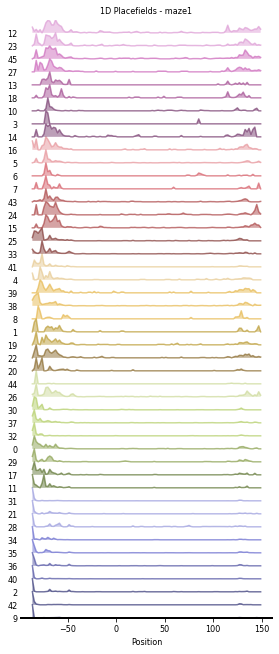

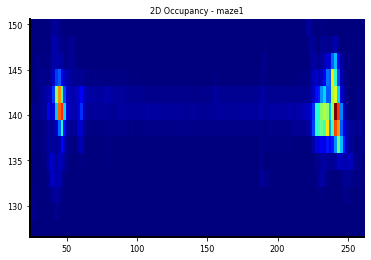

Saving 2D Placefield image out to "output\2006-6-08_14-26-15\maze1\2D Occupancy - maze1.pdf"...
	 done.
Saving 2D Placefield image out to "output\2006-6-08_14-26-15\maze1\2D Placefields - maze1.pdf"...
	 done.
good_placefield_neuronIDs: [  5   8  10  13  14  16  19  21  23  25  28  31  32  33  36  37  41  49
  52  53  54  55  57  59  60  61  62  63  64  66  68  69  74  75  76  78
  83  86  88  89  90  92  96  98 105 108]; (46 good)


In [ ]:
from neuropy.analyses import Pf1D, Pf2D, perform_compute_placefields, plot_all_placefields
from neuropy.plotting.spikes import get_neuron_colors

should_force_recompute_placefields = True
should_display_2D_plots = True
# Setup the placefield computation config
# active_config.computation_config = PlacefieldComputationParameters(speed_thresh=3, grid_bin=2, smooth=2)
active_config.computation_config = PlacefieldComputationParameters(speed_thresh=9, grid_bin=2, smooth=0.5)

def compute_placefields_as_needed(active_epoch_placefields1D = None, active_epoch_placefields2D = None, should_force_recompute_placefields=False, should_display_2D_plots=False):
    active_epoch_placefields1D, active_epoch_placefields2D = perform_compute_placefields(active_epoch_session.neurons, active_epoch_session.position, active_config.computation_config, active_epoch_placefields1D, active_epoch_placefields2D, should_force_recompute_placefields=True)
    # Plot the placefields computed and save them out to files:
    if should_display_2D_plots:
        ax_pf_1D, occupancy_fig, active_pf_2D_figures = plot_all_placefields(active_epoch_placefields1D, active_epoch_placefields2D, active_config)
    else:
        print('skipping 2D placefield plots')
    return active_epoch_placefields1D, active_epoch_placefields2D
        
try: active_epoch_placefields1D
except NameError: active_epoch_placefields1D = None # Checks variable active_epoch_placefields's existance, and sets its value to None if it doesn't exist so it can be checked in the next step
try: active_epoch_placefields2D
except NameError: active_epoch_placefields2D = None # Checks variable active_epoch_placefields's existance, and sets its value to None if it doesn't exist so it can be checked in the next step

active_epoch_placefields1D, active_epoch_placefields2D = compute_placefields_as_needed(active_epoch_placefields1D, active_epoch_placefields2D, should_force_recompute_placefields=True, should_display_2D_plots=should_display_2D_plots)
    
# Focus on the 2D placefields:
active_epoch_placefields = active_epoch_placefields2D
# Get the cell IDs that have a good place field mapping:
good_placefield_neuronIDs = np.array(active_epoch_placefields.ratemap.neuron_ids) # in order of ascending ID
print('good_placefield_neuronIDs: {}; ({} good)'.format(good_placefield_neuronIDs, len(good_placefield_neuronIDs)))

## Filter by neurons with good placefields only:
active_epoch_session = active_epoch_session.get_by_id(good_placefield_neuronIDs) # Filter by good placefields only, and this fetch also ensures they're returned in the order of sorted ascending index ([ 2  3  5  7  9 12 18 21 22 23 26 27 29 34 38 45 48 53 57])
# active_epoch_session_Neurons = active_epoch_session.neurons

## Plotting Colors:
def build_units_colormap(session):
    pf_sort_ind = np.array([int(i) for i in np.arange(len(session.neuron_ids))]) # convert to integer scalar array
    pf_colors = get_neuron_colors(pf_sort_ind) # [4 x n_neurons]: colors are by ascending index ID
    pf_colormap = pf_colors.T # [n_neurons x 4] Make the colormap from the listed colors, used seemingly only by 'runAnalysis_PCAandICA(...)'
    pf_listed_colormap = ListedColormap(pf_colormap)
    return pf_sort_ind, pf_colors, pf_colormap, pf_listed_colormap


pf_sort_ind, pf_colors, pf_colormap, pf_listed_colormap = build_units_colormap(active_epoch_session)
active_config.plotting_config.pf_sort_ind = pf_sort_ind
active_config.plotting_config.pf_colors = pf_colors
active_config.plotting_config.active_cells_colormap = pf_colormap
active_config.plotting_config.active_cells_listed_colormap = ListedColormap(active_config.plotting_config.active_cells_colormap)


In [ ]:
## ICA and PCA Analysis
should_show_2D_ICA_plots = False
from PhoPositionalData.analysis.neuronal_dimensionality_reduction import runAnalysis_PCAandICA
active_session_ensembles, template, zsc_template, pca_data = runAnalysis_PCAandICA(active_epoch_session.neurons, bin_size=0.250, frate_thresh=0.1, should_plot=should_show_2D_ICA_plots, active_cells_colormap=active_config.plotting_config.active_cells_colormap)

In [ ]:
active_epoch_session.spikes_df

In [ ]:
debug_print_spike_counts(active_epoch_session) # 46 neurons after filtering, much better

In [ ]:
# count_arr = np.bincount(active_epoch_session.spikes_df['unit_id'])
# count_arr


valid_indicies = np.nonzero(active_epoch_session.spikes_df['unit_id'].values)
valid_indicies
# count_arr = np.bincount(active_epoch_session.spikes_df['aclu'])
# count_arr

# len(active_epoch_session.spikes_df['unit_id'].values) # 17766


active_epoch_session.neurons.n_spikes

# active_epoch_session.neurons.n_spikes # array([ 513,  473,   33,  630,  130,  631,  150,  349,  308,  952, 1436,
#         # 898,  342,  223, 1261,  684,  916,  137,  293,  687,  394,  225,
#         # 495, 2123,  316,  111,  396,  458,  576,  927,  382])
        


# array([   0,    0,  513,  473,   33,  630,    0,  130,    0,  631,    0,
#         150,  349,    0,    0,    0,    0,  308,  952,    0,    0, 1436,
#         898,  342,  223,    0,    0, 1261,  684,  916,    0,    0,    0,
#         137,  293,    0,    0,    0,  687,  394,    0,    0,  225,    0,
#         495, 2123,  316,  111,  396,    0,    0,    0,    0,  458,    0,
#         576,    0,  927,  382], dtype=int64)

## Laps

In [ ]:
# active_sess_laps_bak = sess.laps
active_epoch_session.laps = sess.laps
# active_epoch_session.flattened_spiketrains.spikes_df
# active_epoch_session.laps
# active_epoch_session.laps.lap_start_stop_time goes from 190.4446 to 5607.2581, and looks like it would match the value on my "curr_i" slider in the plotter if I multiplied it by 10, as the max value on the plotter is "57912.00"
# Plotter's slider: "57912.00": curr_i: 57265, t_start: 1910.79, t_stop: 1920.74. Note the slider fails to update at the end, so curr_i is probably a full value.
active_epoch_session.laps.lap_start_stop_slider_values = active_epoch_session.laps.lap_start_stop_time * 10.0
# active_epoch_session.laps

In [ ]:
active_sess_laps = active_epoch_session.laps
print('active_epoch_session.laps.n_laps: {}'.format(active_epoch_session.laps.n_laps))
# print('active_sess_laps: {}'.format(active_sess_laps))
active_sess_laps.lap_start_stop_time # [  96.0589, 6223.86  ], [ 190.4446, 6285.0087], ... these values look like 't' format, not 't_seconds'
# active_sess_laps.laps_spike_counts
# active_sess_laps.lap_start_stop_flat_idx
def get_lap_flat_indicies(lap_id):
    start_stop = active_sess_laps.lap_start_stop_flat_idx[lap_id,:] # array([ 15841., 900605.]) the start_stop time for the first lap
    return start_stop[0], start_stop[1]

def get_lap_times(lap_id):
    start_stop = active_sess_laps.lap_start_stop_time[lap_id,:] # array([ 886.4489000000001, 931.6386]) the start_stop time for the first lap
    return start_stop[0], start_stop[1]

def build_lap_specific_lists(active_epoch_session):
    # Group by the lap column:
    lap_grouped_spikes_df = active_epoch_session.flattened_spiketrains.spikes_df.groupby(['lap']) #  as_index=False keeps the original index
    
    lap_specific_subsessions = list()
    lap_specific_dataframes = list()
    lap_spike_indicies = list()
    lap_spike_t_seconds = list()
    for i in np.arange(active_epoch_session.laps.n_laps):
        curr_lap_id = active_epoch_session.laps.lap_id[i]
        #curr_flat_cell_indicies = (flat_spikes_out_dict['aclu'] == active_epoch_placefields1D, active_epoch_placefields2D) # the indicies where the cell_id matches the current one
        # print('curr_lap_id: {}'.format(curr_lap_id))
        if curr_lap_id in lap_grouped_spikes_df.groups.keys():
            curr_lap_dataframe = lap_grouped_spikes_df.get_group(curr_lap_id)
            lap_specific_dataframes.append(curr_lap_dataframe)
            lap_spike_indicies.append(curr_lap_dataframe.flat_spike_idx.values)
            lap_spike_t_seconds.append(curr_lap_dataframe.t_seconds.values)
            lap_specific_subsessions.append(active_epoch_session.time_slice(curr_lap_dataframe.t_seconds.values[0], curr_lap_dataframe.t_seconds.values[-1]))
        else:
            # curr_lap_dataframe = pd.DataFrame()
            lap_specific_dataframes.append([])
            lap_spike_indicies.append([])
            lap_spike_t_seconds.append([])
            lap_specific_subsessions.append(None)
        # curr_lap_spike_indicies = curr_lap_dataframe.flat_spike_idx.values
        # lap_spike_indicies.append(curr_lap_dataframe.flat_spike_idx.values)
        # spiketrains.append(curr_cell_dataframe[time_variable_name].to_numpy())
        # shank_ids[i] = curr_cell_dataframe['shank'].to_numpy()[0] # get the first shank identifier, which should be the same for all of this curr_cell_id
        # cell_quality[i] = curr_cell_dataframe['qclu'].mean() # should be the same for all instances of curr_cell_id, but use mean just to make sure
        # cell_type.append(curr_cell_dataframe['cell_type'].to_numpy()[0])
    return lap_specific_subsessions, lap_specific_dataframes, lap_spike_indicies, lap_spike_t_seconds
        
    
    
# curr_lap_id = 4
# curr_lap_t_start, curr_lap_t_stop = get_lap_times(curr_lap_id)
# print('lap[{}]: ({}, {})'.format(curr_lap_id, curr_lap_t_start, curr_lap_t_stop))
print('lap_ids: {}'.format(active_epoch_session.laps.lap_id))
lap_specific_subsessions, lap_specific_dataframes, lap_spike_indicies, lap_spike_t_seconds = build_lap_specific_lists(active_epoch_session)
# print('lap_spike_indicies: {}'.format(lap_spike_indicies))
# lap_spike_indicies[4] # all spike indicies that occured within the lap
# sess.laps.n_laps
# lap_specific_dataframes[4]
# lap_specific_subsessions[4].position.traces
# np.shape(lap_specific_subsessions[4].position.traces) # (2, 1299)

In [ ]:
active_epoch_session.spikes_df

## Main Spike/Placemap plotting:

# Plot Placemaps on 3D Plot

## Tuning Curves 3D Plot:

In [43]:
from PhoGui.InteractivePlotter.InteractivePlaceCellTuningCurvesDataExplorer import InteractivePlaceCellTuningCurvesDataExplorer
try: pActiveTuningCurvesPlotter
except NameError: pActiveTuningCurvesPlotter = None # Checks variable p's existance, and sets its value to None if it doesn't exist so it can be checked in the next step
ipcDataExplorer = InteractivePlaceCellTuningCurvesDataExplorer(active_config, active_epoch_session, active_epoch_placefields, pf_colors, extant_plotter=pActiveTuningCurvesPlotter)
pActiveTuningCurvesPlotter = ipcDataExplorer.plot(pActiveTuningCurvesPlotter) # [2, 17449]

Applying custom Pyvista theme.
done.
No open BackgroundPlotter
Creating a new BackgroundPlotter


C:\Users\Pho\repos\NeuroPy\neuropy\utils\mathutil.py:23: RuntimeWarning: invalid value encountered in true_divide
  return (x - np.min(x, axis=axis, keepdims=True)) / np.ptp(


num_curr_tuning_curves: 46
_update_placefield_spike_visibility(active_cell_local_index: [0], invert: False)
update_placefield_spike_visibility(active_original_cell_unit_ids: [5], invert: False)
	 active_original_cell_unit_ids: [5]
hide_placefield_spikes(active_index: [5], should_invert: False)
	 num_mesh_cells: 124362, num_ghosts: 0
	 updating plot!
_update_placefield_spike_visibility(active_cell_local_index: [1], invert: False)
update_placefield_spike_visibility(active_original_cell_unit_ids: [8], invert: False)
	 active_original_cell_unit_ids: [8]
hide_placefield_spikes(active_index: [8], should_invert: False)
	 num_mesh_cells: 124362, num_ghosts: 1421
	 updating plot!
_update_placefield_spike_visibility(active_cell_local_index: [2], invert: False)
update_placefield_spike_visibility(active_original_cell_unit_ids: [10], invert: False)
	 active_original_cell_unit_ids: [10]
hide_placefield_spikes(active_index: [10], should_invert: False)
	 num_mesh_cells: 124362, num_ghosts: 0
	 updatin

In [40]:
# def plot_placefields2D(pTuningCurves, active_placefields, pf_colors: np.ndarray, zScalingFactor=10.0, show_legend=False):

#     # .threshold().elevation()

#     curr_tuning_curves = active_placefields.ratemap.normalized_tuning_curves
#     # curr_tuning_curves[curr_tuning_curves < 0.1] = np.nan
#     curr_tuning_curves = curr_tuning_curves * zScalingFactor

#     num_curr_tuning_curves = len(curr_tuning_curves)
#     # Get the cell IDs that have a good place field mapping:
#     good_placefield_neuronIDs = np.array(active_placefields.ratemap.neuron_ids) # in order of ascending ID
#     tuningCurvePlot_x, tuningCurvePlot_y = np.meshgrid(active_placefields.ratemap.xbin_centers, active_placefields.ratemap.ybin_centers)

#     pdata_currActiveNeuronTuningCurve = pv.StructuredGrid(tuningCurvePlot_x, tuningCurvePlot_y, curr_active_neuron_tuning_Curve)
#     pdata_currActiveNeuronTuningCurve["Elevation"] = curr_active_neuron_tuning_Curve.ravel(order="F")
        
#     return pTuningCurves

# plot_placefields2D(pTuningCurves, active_epoch_placefields

# ipcDataExplorer.plots['spikes_pf_active']['cellID']

# only_active_colormap = ipcDataExplorer.active_config.plotting_config.active_cells_listed_colormap.copy()
# only_active_colormap
test_full_pc_data = ipcDataExplorer.plots_data['spikes_pf_active']['historical_spikes_pc']

# test_subset = test_full_pc_data.GetCellGhostArray()
# test_subset = test_full_pc_data.GetCellData() # vtkmodules.vtkCommonDataModel.vtkCellData
# test_subset = test_full_pc_data[test_full_pc_data['cellID'] == 55] # vtkmodules.vtkCommonDataModel.vtkCellData

# test_subset = test_full_pc_data.GetGhostArray() # [test_full_pc_data['cellID'] == 55] # vtkmodules.vtkCommonDataModel.vtkCellData


unique_ids = np.unique(test_full_pc_data['cellID']) # array([ 0,  1,  2,  3,  5,  7,  9, 10, 15, 16, 19, 20, 21, 22, 25, 26, 27, 31, 32, 36, 37, 40, 42, 43, 44, 45, 46, 51, 53, 55, 56])
# count_arr = np.bincount(test_full_pc_data['cellID'])
count_arr
# array([ 3591,  3311,   231,  4410,     0,   910,     0,  4417,     0,
#         1050,  2443,     0,     0,     0,     0,  2156,  6664,     0,
#            0, 10052,  6286,  2394,  1561,     0,     0,  8827,  4788,
#         6412,     0,     0,     0,   959,  2051,     0,     0,     0,
#         4809,  2758,     0,     0,  1575,     0,  3465, 14861,  2212,
#          777,  2772,     0,     0,     0,     0,  3206,     0,  4032,
#            0,  6489,  2674], dtype=int64)

# good_placefield_neuronIDs: [  5   8  10  13  14  16  19  21  23  25  28  31  32  33  36  37  41  49
#   52  53  54  55  57  59  60  61  62  63  64  66  68  69  74  75  76  78
#   83  86  88  89  90  92  96  98 105 108]; (46 good)

# 1, 4, 6, 7, 8, 11, 18, 19, 21 ## CONCLUSION: the ones that work are indeed the non-zero entries, but the checkboxes work in reverse order to this array that's printed. Meaning you start at the end and work back.
# len(count_arr) # 107
print(unique_ids) # [  3   6   8  11  12  14  17  19  21  23  26  29  30  31  34  35  39  47
  # 50  51  52  53  55  57  58  59  60  61  62  64  66  67  72  73  74  76
  # 81  84  86  87  88  90  94  96 103 106]


uniques, indicies, inverse_indicies, count_arr = np.unique(active_epoch_session.spikes_df['aclu'].values, return_index=True, return_inverse=True, return_counts=True)
# count_arr = np.bincount(active_epoch_session.spikes_df['aclu'].values)
print('active_epoch_session.spikes_df unique aclu values: {}'.format(uniques))
print('active_epoch_session.spikes_df unique aclu value counts: {}'.format(count_arr))
print(len(uniques)) # 46 
uniques, indicies, inverse_indicies, count_arr = np.unique(active_epoch_session.spikes_df['unit_id'].values, return_index=True, return_inverse=True, return_counts=True)
# count_arr = np.bincount(active_epoch_session.spikes_df['unit_id'].values)
print('active_epoch_session.spikes_df unique unit_id values: {}'.format(uniques))
print('active_epoch_session.spikes_df unique unit_id value counts: {}'.format(count_arr))
print(len(uniques)) # 46 



[  3   6   8  11  12  14  17  19  21  23  26  29  30  31  34  35  39  47
  50  51  52  53  55  57  58  59  60  61  62  64  66  67  72  73  74  76
  81  84  86  87  88  90  94  96 103 106]
active_epoch_session.spikes_df unique aclu values: [  5   8  10  13  14  16  19  21  23  25  28  31  32  33  36  37  41  49
  52  53  54  55  57  59  60  61  62  63  64  66  68  69  74  75  76  78
  83  86  88  89  90  92  96  98 105 108]
active_epoch_session.spikes_df unique aclu value counts: [ 404  150  203   23  323  684  101   61   75   53  289  157 1044  137
  393  931  400  248  286  368  162  156  472  756  451  529 1278  387
  184  287  337  223  248  699  225  725  349  603  682  231  274  240
  145  629   32 1132]
46
active_epoch_session.spikes_df unique unit_id values: [  3   6   8  11  12  14  17  19  21  23  26  29  30  31  34  35  39  47
  50  51  52  53  55  57  58  59  60  61  62  64  66  67  72  73  74  76
  81  84  86  87  88  90  94  96 103 106]
active_epoch_session.spikes_df uniqu

In [ ]:
# pActiveTuningCurvesPlotter.export_obj('export.obj')
# pActiveTuningCurvesPlotter.export_gltf('export.gltf')

ipcDataExplorer.update_placefield_spike_visibility([38], True) # seems to work

In [ ]:
ipcDataExplorer.update_placefield_spike_visibility([53], True) # seems to work

In [ ]:
ipcDataExplorer.update_placefield_spike_visibility([44, 53], True) # seems to work

# test_subset
# test_subset

In [ ]:
ipcDataExplorer.update_placefield_spike_visibility([53, 44], False) # seems to work

In [ ]:
ipcDataExplorer.gui['tuningCurveSpikeVisibilityCallbacks'][1](False)
# ipcDataExplorer.get_cell_index([2, 3])

In [ ]:
mesh = ipcDataExplorer.plots_data['spikes_pf_active']['historical_spikes_pc'].cast_to_unstructured_grid()
# mesh.n_cells
mesh_unique_ids = np.unique(mesh['cellID'])
print('n_cells: {}'.format(mesh.n_cells)) # 122143
print('cellIDs of mesh: {}'.format(mesh_unique_ids))
# np.unique(mesh['cellID']) # array([ 0,  1,  2,  3,  5,  7,  9, 10, 15, 16, 19, 20, 21, 22, 25, 26, 27, 31, 32, 36, 37, 40, 42, 43, 44, 45, 46, 51, 53, 55, 56])
# ipcDataExplorer.hide_placefield_spikes([0,1,2,3], should_invert=True)
# ipcDataExplorer.hide_placefield_spikes([23,2,34], should_invert=True)

# ipcDataExplorer.hide_placefield_spikes([34], should_invert=True)
ipcDataExplorer.hide_placefield_spikes([38], should_invert=False)

In [ ]:
# the list of spike times that occured for this cell:
i = 2
active_epoch_session.neurons.neuron_ids[i]
active_epoch_session.neurons.spiketrains[i]

# spikes_df = FlattenedSpiketrains.build_spike_dataframe(sess)


## Interactive 3D Spike and Behavior Browser: 

In [ ]:
import PhoGui
from PhoGui.InteractivePlotter.PhoInteractivePlotter import PhoInteractivePlotter
from PhoGui.InteractivePlotter.shared_helpers import InteractivePyvistaPlotterBuildIfNeededMixin
from PhoGui.InteractivePlotter.InteractivePlaceCellDataExplorer import InteractivePlaceCellDataExplorer

active_config.plotting_config.show_legend = True

try: pActiveInteractivePlaceSpikesPlotter
except NameError: pActiveInteractivePlaceSpikesPlotter = None # Checks variable p's existance, and sets its value to None if it doesn't exist so it can be checked in the next step
ipspikesDataExplorer = InteractivePlaceCellDataExplorer(active_config, active_epoch_session, extant_plotter=pActiveInteractivePlaceSpikesPlotter)
pActiveInteractivePlaceSpikesPlotter = ipspikesDataExplorer.plot(pActivePlotter=pActiveInteractivePlaceSpikesPlotter)

# Programmatically change the animal position trail:

In [ ]:
def plot_lap_trajectory_path(ipspikesDataExplorer, curr_lap_position_traces):
    num_lap_samples = np.shape(curr_lap_position_traces)[1]
    lap_fixed_z = np.full_like(curr_lap_position_traces[0,:], 0.9)
    plot_name = 'lap_location_trail'
    # fade_values = ipspikesDataExplorer.params.active_trail_opacity_values
    # size_values = ipspikesDataExplorer.params.active_trail_size_values
    trail_fade_values = None
    size_values = None
    # trail_fade_values = np.linspace(0.0, 0.6, num_lap_samples)
    size_values = np.linspace(0.2, 0.6, num_lap_samples) # fade from a scale of 0.2 to 0.6
    ipspikesDataExplorer.perform_plot_location_trail(plot_name, curr_lap_position_traces[0,:], curr_lap_position_traces[1,:], lap_fixed_z,
                                                 trail_fade_values=trail_fade_values, trail_point_size_values=size_values,
                                                 render=True, color='red')

# def hide_lap_trajectory_path(ipspikesDataExplorer):
    



    
## ACTIVE: Laps and Spikes:

# def visually_indicate_current_lap(
curr_lap_id = 0

curr_lap_t_start, curr_lap_t_stop = get_lap_times(curr_lap_id)
curr_lap_subsession = lap_specific_subsessions[curr_lap_id]
curr_lap_dataframe = lap_specific_dataframes[curr_lap_id] # the subset dataframe for this lap
curr_lap_spike_t_seconds = curr_lap_dataframe.t_seconds
curr_lap_spike_indicies = lap_spike_indicies[curr_lap_id] # all spike indicies that occured within the lap
curr_lap_position_traces = curr_lap_subsession.position.traces # the animal positions that were traversed during this lap

curr_lap_num_spikes = len(curr_lap_spike_indicies)
print('lap[{}]: ({}, {}): {} spikes.'.format(curr_lap_id, curr_lap_t_start, curr_lap_t_stop, curr_lap_num_spikes))

test_flat_times = active_epoch_session.flattened_spiketrains.flattened_spike_times
print(test_flat_times)
    
plot_lap_trajectory_path(ipspikesDataExplorer, curr_lap_position_traces)
# curr_lap_t_start
## TODO: enable showing/hiding the spikes for this data range programmatically in InteractivePlaceCellDataExplorer. 
# ipspikesDataExplorer.
# curr_lap_spike_t_seconds
# curr_lap_spike_indicies
# active_epoch_session.flattened_spiketrains.spikes_df.t_seconds.values[curr_lap_spike_indicies] # index 145937 is out of bounds for axis 0 with size 19647

In [ ]:
renderWindow.SetWindowName('Test')
# ipspikesDataExplorer.on_programmatic_data_update(active_included_all_historical_indicies=curr_lap_spike_indicies, active_included_recent_only_indicies=curr_lap_spike_indicies) # index 145937 is out of bounds for axis 0 with size 19647
# ipspikesDataExplorer.on_programmatic_data_update(active_included_all_historical_indicies=curr_lap_spike_t_seconds, active_included_recent_only_indicies=curr_lap_spike_t_seconds) # 
# ipspikesDataExplorer.on_programmatic_data_update(active_included_all_historical_indicies=curr_lap_spike_t_seconds.values, active_included_recent_only_indicies=curr_lap_spike_t_seconds.values) # 

In [ ]:
# ipspikesDataExplorer.spikes_main_historical.SetVisibility(0)

# ipspikesDataExplorer.spikes_main_historical.SetVisibility(1)
# bool(ipspikesDataExplorer.spikes_main_historical.GetVisibility())

ipspikesDataExplorer.toggle_plot_visibility('spikes_main_historical')
# toggle_visibility(ipspikesDataExplorer.spikes_main_historical)

In [ ]:
ipspikesDataExplorer.toggle_plot_visibility('lap_location_trail')

In [ ]:
# ipspikesDataExplorer.spikes_main_recent_only.SetVisibility(True)
toggle_visibility(ipspikesDataExplorer.spikes_main_recent_only)

In [ ]:
# ipspikesDataExplorer.animal_location_trail.SetVisibility(0)
toggle_visibility(ipspikesDataExplorer.animal_location_trail)

In [ ]:
# ipspikesDataExplorer.animal_location_trail.SetVisibility(0)
toggle_visibility(ipspikesDataExplorer.animal_current_location_point)

# Programmatically change the animals location point indicator:

In [ ]:
# .GetPosition() returns the actor's position, which is usually (0.0, 0.0, 0.0), and does not relate to the actor's data points
# curr_animal_point = ipspikesDataExplorer.animal_location_trail.GetPosition()
# curr_animal_point = ipspikesDataExplorer.animal_location_trail.GetXRange() # (44.23604202270508, 245.9059600830078)
# print(curr_animal_point)
# curr_animal_point = ipspikesDataExplorer.animal_location_trail.GetYRange() # (135.27638244628906, 145.448974609375)
# print(curr_animal_point)
# curr_animal_point = ipspikesDataExplorer.animal_location_trail.GetZRange() # (1.100000023841858, 1.100000023841858)

curr_animal_point = np.array(ipspikesDataExplorer.animal_location_trail.GetCenter()) # (206.27755737304688, 140.15452575683594, 1.100000023841858)
print('curr_animal_point: {}'.format(curr_animal_point))
curr_animal_point # curr_animal_poin

# curr_animal_point = np.array([0, 0, 0])

# curr_animal_point = np.column_stack((self.x[active_window_sample_indicies], self.y[active_window_sample_indicies], self.z_fixed))
# ipspikesDataExplorer.on_programmatic_data_update(curr_animal_point=curr_animal_point)

curr_debug_point = np.array(ipspikesDataExplorer.animal_location_trail.GetCenter()) # (206.27755737304688, 140.15452575683594, 1.100000023841858)
ipspikesDataExplorer.perform_plot_location_point('debug_point_plot', curr_animal_point, color='r')

curr_animal_point = np.array(ipspikesDataExplorer.animal_location_trail.GetCenter()) # not updated
print('new curr_animal_point: {}'.format(curr_animal_point))

In [ ]:
# ipspikesDataExplorer.flattened_spike_positions_list

active_epoch_session.flattened_spiketrains.time_slice(curr_lap_spike_t_seconds.values[0], curr_lap_spike_t_seconds.values[-1]).spikes_df

In [ ]:
curr_lap_dataframe

In [ ]:
active_epoch_session.time_slice